ENCRYPTION
==========
Start (x0, y0, z0)
   ↓
Run RK4 Step ➜ Get x
   ↓
x' = x mod p
   ↓
Does x' fall in target cell?
    ├── No → Step++
    └── Yes
           ↓
     Generate random k ∈ [0,1]
           ↓
     Is k > η?
         ├── Yes → Accept n as encryption
         └── No  → Keep running

DECRYPTION
==========
Start (x0, y0, z0)
   ↓
Run RK4 for n_i steps
   ↓
x' = x mod p
   ↓
Find cell index = floor((x' - vmin)/ε)
   ↓
Get ASCII char from cell


In [152]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random

# Lorenz system of differential equations
def lorenz(t, state,sigma, beta, rho):#t is used for iteration identification in solution even iif ot not used in  this function
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    new_state=[dxdt, dydt, dzdt]
    return new_state

def trajectory_generator(sigma, rho, beta, initial_state, t_span, number_evaluation_points):
    t_eval = np.linspace(*t_span, number_evaluation_points)  # number_evalution_points is like on how many points we want to generate lorenz value
    # Solve the system / Trajectory formation
    solution = solve_ivp(lorenz, t_span, initial_state, t_eval=t_eval, args=(sigma, beta, rho))
    return solution

def trajectory_folding(solution,axis,p):
    #axis: 0 for x-axis ,1 for y-aixs ,2 for z-axis , you can choose anyone aixs for encryption
    #p = trajectory_folding parameter , generally lies in [1,5]
    v_values_from_lorenz= solution.y[axis]
    #Trajectory Folding
    folded_v_values=[ele%p for ele in v_values_from_lorenz] # Transformed values
    return folded_v_values

def traget_range_generator(p):
    #episilon = (Vmax- Vmin)/S  
    #generally Vmin =0 , Vmax = 1 , S = 256
    #Vmax = p 
    cell_value=p/256       #defining target cell [0,1) / 256
    # print(cell_value)
    target_cells=[]
    for i in range (1,257):
        lst=[(i-1)*cell_value,i*cell_value]
        target_cells.append(lst)
    if(len(target_cells)!=256):
        print("Error in target range calculation") 
    return target_cells


In [153]:
def encrypt(
    text,
    sigma = 10,
    rho = 28,
    beta = 8 / 3,
    initial_state = [1.0, 1.0, 1.0],
    t_span = (0, 40),
    number_evaluation_points = 60000,
    axis=0,
    p=1
    ):
    '''
    Arguments 
        text = Normal English Message
        Lorenz Dynamics Simulation Parameters : 
            sigma , rho, beta, initial state
        t_span = for which time period the dynamics should generate (Time Range )
        number_evaluation_points = how many iterations we need for t_span
        axis : user is allowed to choose which of three (x,y,z)axis is used in encrption. 0->x , 1->y  , 2->z axis respectivley.
        p : Trajectory Folding parameter , it helps to convert dynamics values to nomarlize or bounded values within a range

    Returns
    cipher text : List of Integers which represents the Encrypted Message . (Even same letters of same csae can have different value in this encryption)
                The same message will have many possibilities of encrypted cipher texts.
    '''
    solution=trajectory_generator(sigma,rho,beta,initial_state,t_span,number_evaluation_points)
    transformed_v_values=trajectory_folding(solution,axis,p)#Solutions values nor,alised to be lie in [0,1)
    target_cells=traget_range_generator(p)#each target cell is [x1,x2) Remember to make this chekc !
    extended_ascii_char =[chr(i) for i in range(256)] #in encryption the steps/iteartions to reach the value will be used for cipher
    #mapping
    cipher_text=[] 
    threshold = 0.75 # used for extra randomness such that same msg / same char would have different cipher text for same parameters
    for character in text :
        char_index = extended_ascii_char.index(character) # char index in extended ascii
        # print(char_index)
        target_cell = target_cells[char_index]
        # print(target_cell)
        # flag=1
        for i in range(10000,len(transformed_v_values)):#First 10k points are discarded for encryption as they are Trainsient.
            if(transformed_v_values[i]>=target_cell[0] and transformed_v_values[i]<target_cell[1]):#lie in the same site , same cell
                #steps = i , that is our cipher char
                k=random.random()#Extra randomness
                if k>threshold:
                    cipher_text.append(i)
                    flag=0
                    break
        # if(flag):#Inner for loop khtam but charcter found nhi huya then add more points
        #     #Mkae chnage to generate the solutions value for new points new states 
    print("Your Encrypted Message is :  ",cipher_text)
    # print(len(cipher_text))

    if(len(cipher_text)!=len(text)):
        print("Error somewhere in cipher_text mapping")

    ################################Prints to Check !
    # Plotting the Lorenz attractor
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(projection='3d')
    ax.plot(solution.y[0], solution.y[1], solution.y[2], color='crimson', linewidth=0.8)
    ax.set_title("Lorenz attractor — a chaotic trajectory in 3D space defined by the Lorenz dynamics")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()
    print(solution)
    print(solution.y[0])
    print(len(solution.y[0]))
    print(solution.y[1])
    print(len(solution.y[1]))
    print(solution.y[2])
    print(len(solution.y[2]))
    print("")
    print("")
    print(solution.y[1])
    print(len(solution.y[1]))
    print(transformed_v_values)
    print(len(transformed_v_values))
    print(target_cells)
    print(len(target_cells))
    print(extended_ascii_char)
    print(len(extended_ascii_char))
    print(text)
    print(cipher_text)
    print(len(cipher_text))

    return cipher_text

In [154]:
def main() :
    text = input("Enter Text to encrypt(Using Lorenz Chaotic Encryption): ")
    print("Original Message : ",text)
    print("\nConfiguration")
    # Lorenz system parameters user defined
    # sigma = 10,
    # rho = 28,
    # beta = 8 / 3,
    # initial_state = [1.0, 1.0, 1.0],
    # t_span = (0, 40),
    # number_evaluation_points = 60000,
    # axis=0,
    # p=1

    sigma = int(input("\n Enter Sigma value (generally 10): "))
    rho = int(input(" Enter Rho value (generally 28): "))
    beta = input("Enter a Beta value (e.g., 8/3): ")
    if '/' in beta:
        num, den = beta.split('/')
        beta = float(num) / float(den)
    else:
        beta = float(beta)

    initial_state = input("Enter Initial State (Enter a list of floats (space-separated)) ( generally [1.0,1.0,1.0]): ")
    initial_state = [float(x) for x in initial_state.strip().split()]

    t_span = input("Enter Time Span/Time Range (space-separated) (generally (0 40) ): ")
    t_span = tuple(float(x) for x in t_span.strip().split())

    number_evaluation_points = int(input(" Enter Number of Evaluation Points (generally 60000): "))

    axis = int(input("\n Which axis you want to use in encryption (0->x,1->y,2->z) ? :  "))
    p = int(input(" Enter p value (generally 1): ")) 

    print("\tSigma = ",sigma)
    print("\tRho = ",rho)
    print("\tBeta = ",beta)
    print("\tInitial State = ",initial_state)
    print("\tt_span = ",t_span)
    print("\tNumber of Evaluation Points = ",number_evaluation_points)
    print("\tAxis = ",axis)
    print("\tp = ",p)
    
    cipher_text= encrypt(text,sigma,rho,beta,initial_state,t_span,number_evaluation_points,axis,p)
    print("\n\nYour Encrypted Message (Cipher text) is = ",cipher_text)


Original Message :  Hello World!

Configuration
	Sigma =  10
	Rho =  28
	Beta =  2.6666666666666665
	Initial State =  [1.0, 1.0, 1.0]
	t_span =  (0.0, 40.0)
	Number of Evaluation Points =  60000
	Axis =  0
	p =  1
Your Encrypted Message is :   [10824, 11577, 10842, 10030, 10710, 10148, 10636, 11924, 10180, 12471, 10174, 10788]


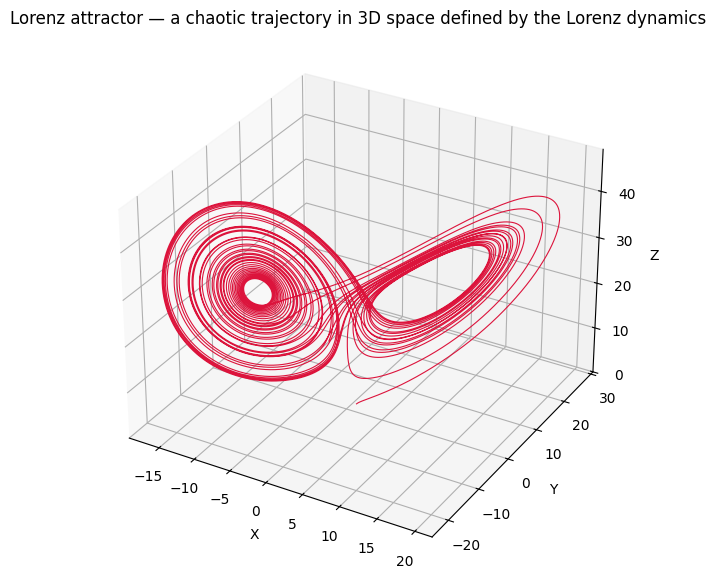

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.667e-04 ...  4.000e+01  4.000e+01]
        y: [[ 1.000e+00  1.000e+00 ... -1.492e+00 -1.496e+00]
            [ 1.000e+00  1.017e+00 ... -2.072e+00 -2.083e+00]
            [ 1.000e+00  9.989e-01 ...  1.577e+01  1.575e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 3728
     njev: 0
      nlu: 0
[ 1.          1.00005704  1.0002277  ... -1.48861561 -1.49245526
 -1.49634105]
60000
[ 1.          1.01732937  1.03465147 ... -2.06109432 -2.07185268
 -2.08266118]
60000
[ 1.          0.99889563  0.99780483 ... 15.80009809 15.77408516
 15.74813447]
60000


[ 1.          1.01732937  1.03465147 ... -2.06109432 -2.07185268
 -2.08266118]
60000
[0.0, 5.7036447808522794e-05, 0.00022770423697626718, 0.0005113483614476166, 0.0009073235822771863, 0.0014149944276280468, 0.0020337351927737224, 0.0027629299400957485, 0.0036019724990863367, 0.00455026646634593

In [155]:
if __name__ == "__main__":
    main()

#General used values

| Parameter | General Value  | Recommended Range | Description                                 |
| --------- | -------------- | ----------------- | ------------------------------------------- |
| `sigma`   | `10.0`         | `8.0 to 12.0`     | Controls rate of change in x-direction      |
| `rho`     | `28.0`         | `24.0 to 35.0`    | Influences z-direction and chaotic behavior |
| `beta`    | `8/3 ≈ 2.6667` | `2.0 to 3.0`      | Controls the compression rate of the system |
| Parameter       | General Value     | Range       | Description                                           |
| --------------- | ----------------- | ----------- | ----------------------------------------------------- |
| `initial_state` | `[1.0, 1.0, 1.0]` | `[-10, 10]` | Starting (x, y, z) position; very sensitive to change |
| Parameter                  | General Value | Description                                                   |
| -------------------------- | ------------- | ------------------------------------------------------------- |
| `t_span`                   | `(0, 40)`     | Simulation duration (start, end time)                         |
| `number_evaluation_points` | `60000`       | Number of steps in integration; higher means finer resolution |
| Parameter | General Value | Options   | Description                                                        |
| --------- | ------------- | --------- | ------------------------------------------------------------------ |
| `axis`    | `0` (x-axis)  | `0, 1, 2` | Choose which Lorenz variable to use (`x`, `y`, or `z`) for mapping |
| Parameter | General Value | Range      | Description                                                       |
| --------- | ------------- | ---------- | ----------------------------------------------------------------- |
| `p`       | `1.0`         | `0.5 to 5` | Folding mod value for periodicity (acts as additional randomness) |

text = "Hello, Chaos!"
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
initial_state = [1.0, 1.0, 1.0]
t_span = (0, 40)
number_evaluation_points = 60000
axis = 0
p = 1.0
